In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from IPython import display as ipythondisplay
import imageio

In [18]:
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start()

### Environment

In [19]:
env = gym.make('CartPole-v1').unwrapped

print(env.action_space.n)
print(env.observation_space)

2
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


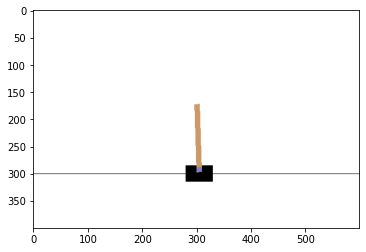

In [20]:
env.reset()
screen = env.render(mode = 'rgb_array')
plt.imshow(screen)

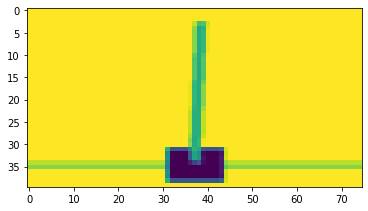

torch.Size([1, 40, 75])


In [21]:
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize = T.Compose([T.ToPILImage(), T.Grayscale(), T.Resize(40, interpolation = Image.BICUBIC), T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen(env):
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, height, width = screen.shape
    screen = screen[:, int(height*0.4):int(height * 0.8)]
    view_width = int(width * 0.5)
    cart_location = get_cart_location(width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
        
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen(env).cpu().squeeze(0).numpy(), interpolation = 'none')
plt.show()

print(get_screen(env).size())

### Agent

In [22]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size = 3, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 5, stride = 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 5, stride = 2)
        self.bn4 = nn.BatchNorm2d(64)

        conv2d_size_out = lambda size, kernel_size = 3, pad = 0, stride = 2 : (size + (2 * pad) - kernel_size) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(w, stride = 1), stride = 1), kernel_size = 5), kernel_size = 5)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(h, stride = 1), stride = 1), kernel_size = 5), kernel_size = 5)
        flatten_input_size = convw * convh * 64
        print(flatten_input_size)
        self.fc1 = nn.Linear(flatten_input_size, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x
  

In [23]:
from collections import deque, namedtuple
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque()

    def push(self, *args):
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
            self.memory.popleft()

    def sample(self, batch_size):
        idx = np.random.choice(len(self.memory), batch_size)
        return np.array(self.memory)[idx]

    def __len__(self):
        return len(self.memory)

In [24]:
class Double_DQN_Agent:
    def __init__(self, env, epsilon = 1.0, lr = 0.0001, gamma = 0.999, bufferSize = 100000, tau = 0.1):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.epsilon = epsilon
        self.gamma = gamma
        _, h, w = get_screen(env).size()
        self.online_net = DQN(h, w, self.action_space.n).to(device)
        self.target_net = DQN(h, w, self.action_space.n).to(device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.online_net.parameters(), lr = lr)
        self.criterion = nn.SmoothL1Loss()
        self.memory = ReplayMemory(bufferSize)
        self.tau = tau

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def step(self, state):
        if np.random.random() < self.epsilon:
            return torch.tensor([[np.random.choice(self.action_space.n)]], device = device, dtype = torch.long)
        else:
            with torch.no_grad():
                return self.online_net(state).max(1)[1].view(1, 1)

    def populateReplayMemory(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)
    
    # ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    def train(self, batch_size = 128):
        if len(self.memory) < 512:
            return
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype = torch.bool)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state = torch.cat(batch.state)
        action = torch.cat(batch.action)
        reward = torch.cat(batch.reward)

        state_action_values = self.online_net(state).gather(1, action)

        next_state_values = torch.zeros(batch_size, device = device)
        # Double DQN update
        next_state_actions = self.target_net(non_terminal_next_states).max(1, keepdim = True)[1]
        next_state_values[non_terminal_mask] = self.online_net(non_terminal_next_states).gather(1, next_state_actions).squeeze(1).detach()
        
        expected_state_action_values = (next_state_values * self.gamma) + reward

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # train the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.online_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def updateWeights(self):
        target_state_dict = self.target_net.state_dict()
        online_state_dict = self.online_net.state_dict()
        for key in online_state_dict:
            target_state_dict[key] = self.tau * online_state_dict[key] + (1 - self.tau) * target_state_dict[key]
        self.target_net.load_state_dict(target_state_dict)

    def test(self):
        self.env.reset()
        images = []
        images.append(self.env.render(mode = 'rgb_array'))
        last_screen = get_screen(self.env)
        state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
        done = False
        self.epsilon = 0
        while not done:
            action = self.step(state)
            _, reward, done, info = self.env.step(action.item())
            images.append(self.env.render(mode = 'rgb_array'))
            next_screen = get_screen(self.env)
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
            state = next_state
        
        imageio.mimsave('result_cartpole.gif', images)
        return images

    def saveWeights(self, path):
        torch.save(self.online_net.state_dict(), path)
    
    def loadWeights(self, path):
        self.online_net.load_state_dict(torch.load(path))


### MDP

In [25]:
agent = Double_DQN_Agent(env)

episodes = 2000
target_update = 10
epsilon = agent.epsilon
epsilons = []
delta_epsilon = epsilon / episodes
epsilons = [epsilon]
total_rewards = []

for episode in range(episodes):
    env.reset()
    done = False
    if episode > 0:
        epsilon = epsilon - (5 * epsilon * delta_epsilon)
        epsilons.append(epsilon)
        agent.set_epsilon(epsilon)
    
    last_screen = get_screen(env)
    # stacking last 4 screens together as state
    state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
    curr_reward = 0
    i = 0
    while not done:
        action = agent.step(state)
        _, reward, done, info = env.step(action.item())
        curr_reward += reward
        reward = torch.tensor([reward], device = device)
        next_screen = get_screen(env)

        if done:
            next_state = None
        else:
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
            
        agent.populateReplayMemory(state, action, next_state, reward)

        state = next_state
        if i % 3 == 0:
            agent.train()
        i += 1
        
    if episode % target_update == 0:
        agent.updateWeights()
    
    total_rewards.append(curr_reward)
    
    if (episode + 1) % 50 == 0:
        print(f'{episode + 1} episode completed')

print('Complete')

5760
5760
50 episode completed
100 episode completed
150 episode completed
200 episode completed
250 episode completed
300 episode completed
350 episode completed
400 episode completed
450 episode completed
500 episode completed
550 episode completed
600 episode completed
650 episode completed
700 episode completed
750 episode completed
800 episode completed
850 episode completed
900 episode completed
950 episode completed
1000 episode completed
1050 episode completed
1100 episode completed
1150 episode completed
1200 episode completed
1250 episode completed
1300 episode completed
1350 episode completed
1400 episode completed
1450 episode completed
1500 episode completed
1550 episode completed
1600 episode completed
1650 episode completed
1700 episode completed
1750 episode completed
1800 episode completed
1850 episode completed
1900 episode completed
1950 episode completed
2000 episode completed
Complete


In [11]:
def plotGraphs(epsilons, total_rewards):
    # Plotting ε vs Episodes
    plt.figure(1)
    plt.title('Epsilon decay')
    plt.xlabel('Episodes')
    plt.ylabel('$\epsilon$')
    plt.plot(epsilons)
    plt.savefig('Epsilon_decay.png')

    # Plotting Total rewards received vs Episodes
    plt.figure(2)
    step = 10
    plt.title('Rewards dynamics')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward (SMA 10)')
    plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])
    plt.savefig('Rewards_dynamics.png')


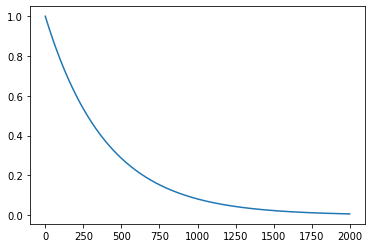

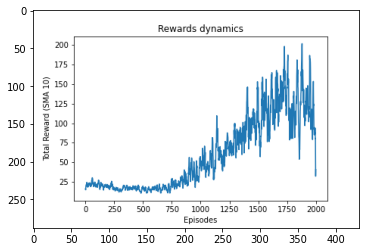

In [28]:
plotGraphs(epsilons, total_rewards)

In [ ]:
agent.saveWeights('DoubleDQN_Cartpole')

In [32]:
agent = Double_DQN_Agent(env)
agent.loadWeights('DoubleDQN_Cartpole')
imgs = agent.test()
len(imgs)

5760
5760


594